In [1]:
import json 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Protein properties file
with open("../protein_properties/proteins.json", "r") as f:
    protein_properties = json.loads(f.read())

len(protein_properties)

20427

In [3]:
# Read from protein's drugs information extracted from DrugBank
with open("../drugbank/protein_drugbank.json", "r") as f:
    drugs = json.loads(f.read())

druggable_prots = []
for k, v in drugs.items():
    for drug, info in v.items():
        if("approved" in info[1]):
            druggable_prots.append(k)
            break 

len(druggable_prots)

2652

#### Machine Learning and AUC-ROC Curves
Using machine learning one both these features, we can predict if a protein is druggable or not
Using 1. SVM - Linear, 2. SVM - RBF, 3. Logisit Regression and 4. KNN
The size of dataset is 2652 druggable and (20427 - 2652) = 17775 non-druggable proteins

We use two different settings
1. We take 80-20 train-test split. With 80 percent from each class as training and 20 percent from each class as testing
2. We randomly choose same number of non druggable proteins as druggable proteins and then do 80-20 train-test split. But since this is random, we do
this around 10 times and then take the average model performance


We overall do 8 experiments - 4 models for each of the two settings

Finally we plot the auc-roc curve for each of the 8 experiments, different colors for different models on same plot, and two different curves for
two different settings

In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve


def plot_roc_curves(X_druggable, X_non_druggable, setting = 1, train_ratio = 0.8, feature = ""):

    # Setting random seed
    random_state = 42
    np.random.seed(random_state)

    # Converting to numpy arrays
    X_druggable = np.array(X_druggable)
    X_non_druggable = np.array(X_non_druggable)

    # Ensure X_druggable and X_non_druggable have shape as 2d
    if len(X_druggable.shape) == 1:
        X_druggable = X_druggable.reshape(-1, 1)
    if len(X_non_druggable.shape) == 1:
        X_non_druggable = X_non_druggable.reshape(-1, 1)
        
    # Shuffle the data
    np.random.shuffle(X_druggable)
    np.random.shuffle(X_non_druggable)

    # Split the data
    if setting == 1:
        X_train = np.concatenate((X_druggable[:int(train_ratio*len(X_druggable))], X_non_druggable[:int(train_ratio*len(X_non_druggable))]), axis=0)
        X_test = np.concatenate((X_druggable[int(train_ratio*len(X_druggable)):], X_non_druggable[int(train_ratio*len(X_non_druggable)):]), axis=0)
        # Labels
        y_train = np.concatenate((np.ones(int(train_ratio*len(X_druggable))), np.zeros(int(train_ratio*len(X_non_druggable)))), axis=0)
        y_test = np.concatenate((np.ones(len(X_druggable) - int(train_ratio*len(X_druggable))), np.zeros(len(X_non_druggable) - int(train_ratio*len(X_non_druggable)))), axis=0)
    elif setting == 2:
        pass ## LATER TODO

    # Shuffle the training data
    data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
    np.random.shuffle(data)
    X_train, y_train = data[:, :-1], data[:, -1]

    # Print shapes of the data splits    
    print("X_train shape: ", X_train.shape)
    print("y_train shape: ", y_train.shape)
    print("X_test shape: ", X_test.shape)
    print("y_test shape: ", y_test.shape)

    # Scaling features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train the models -- 1. Logistic Regression 2. SVM Linear 3. SVM RBF 4. KNN
    clf1 = LogisticRegression(random_state=random_state).fit(X_train, y_train)
    clf2 = SVC(kernel='linear', probability=True, random_state=random_state).fit(X_train, y_train)
    clf3 = SVC(kernel='rbf', probability=True, random_state=random_state).fit(X_train, y_train)
    clf4 = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

    # Predicting probabilities
    y_pred1 = clf1.predict_proba(X_test)[:, 1]
    y_pred2 = clf2.predict_proba(X_test)[:, 1]
    y_pred3 = clf3.predict_proba(X_test)[:, 1]
    y_pred4 = clf4.predict_proba(X_test)[:, 1]

    # Computing ROC AUC scores
    auc1 = roc_auc_score(y_test, y_pred1)
    auc2 = roc_auc_score(y_test, y_pred2)
    auc3 = roc_auc_score(y_test, y_pred3)
    auc4 = roc_auc_score(y_test, y_pred4)
    # Print the scores
    print("Logistic Regression AUC: ", auc1)
    print("SVM Linear AUC: ", auc2)
    print("SVM RBF AUC: ", auc3)
    print("KNN AUC: ", auc4)

    # Plotting ROC curves
    fpr1, tpr1, _ = roc_curve(y_test, y_pred1)
    fpr2, tpr2, _ = roc_curve(y_test, y_pred2)
    fpr3, tpr3, _ = roc_curve(y_test, y_pred3)
    fpr4, tpr4, _ = roc_curve(y_test, y_pred4)

    random_probs = [0 for _ in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

    plt.plot(fpr1, tpr1, linestyle='--', color='orange', label=f'Logistic Regression({auc1:.2f})')
    plt.plot(fpr2, tpr2, linestyle='--', color='green', label=f'SVM Linear({auc2:.2f})')
    plt.plot(fpr3, tpr3, linestyle='--', color='blue', label=f'SVM RBF({auc3:.2f})')
    plt.plot(fpr4, tpr4, linestyle='--', color='red', label=f'KNN({auc4:.2f})')
    plt.plot(p_fpr, p_tpr, linestyle='--', color='black')

    plt.title(f'ROC curve for {feature}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.savefig(f'plots/{feature.lower()}_roc.png')
    plt.show()    

##### Molar Extinction Coefficient

X_train shape:  (16341, 2)
y_train shape:  (16341,)
X_test shape:  (4086, 2)
y_test shape:  (4086,)
Logistic Regression AUC:  0.5923187150534645
SVM Linear AUC:  0.39775812428319046
SVM RBF AUC:  0.5373885220413147
KNN AUC:  0.5447270627560981


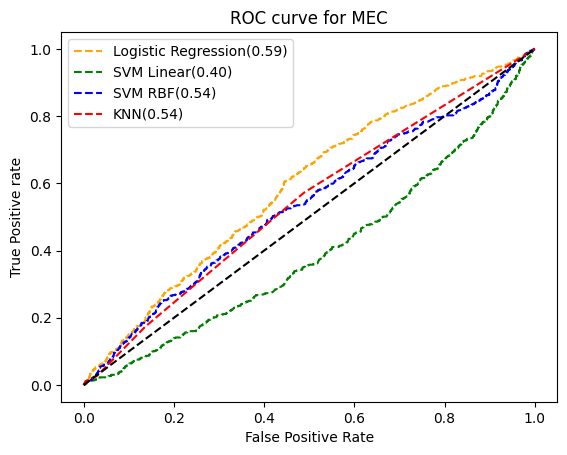

In [68]:
X_druggable = []
X_non_druggable = []

for prot, info in protein_properties.items():
    if prot in druggable_prots:
        X_druggable.append([info['Molar Extinction Coefficient'][0], info["Molar Extinction Coefficient"][1]])
    else:
        X_non_druggable.append([info['Molar Extinction Coefficient'][0], info["Molar Extinction Coefficient"][1]])

plot_roc_curves(X_druggable, X_non_druggable, feature="MEC", setting=1)

##### GRAVY Values

X_train shape:  (16341, 1)
y_train shape:  (16341,)
X_test shape:  (4086, 1)
y_test shape:  (4086,)
Logistic Regression AUC:  0.6220384011272948
SVM Linear AUC:  0.3779613340008105
SVM RBF AUC:  0.45526366672758717
KNN AUC:  0.555575156075764


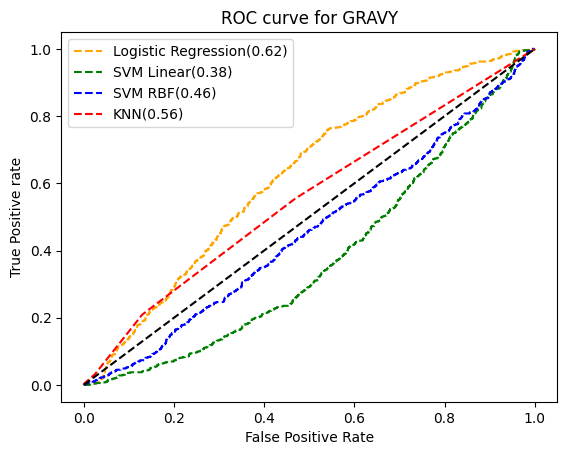

In [69]:
X_druggable = []
X_non_druggable = []

for prot, info in protein_properties.items():
    if prot in druggable_prots:
        X_druggable.append(info['GRAVY'])
    else:
        X_non_druggable.append(info['GRAVY'])

plot_roc_curves(X_druggable, X_non_druggable, feature="GRAVY", setting=1)

##### Isoelectric Point

X_train shape:  (16341, 1)
y_train shape:  (16341,)
X_test shape:  (4086, 1)
y_test shape:  (4086,)
Logistic Regression AUC:  0.5398073321837893
SVM Linear AUC:  0.4601926678162107
SVM RBF AUC:  0.5170617230976238
KNN AUC:  0.5159919055148977


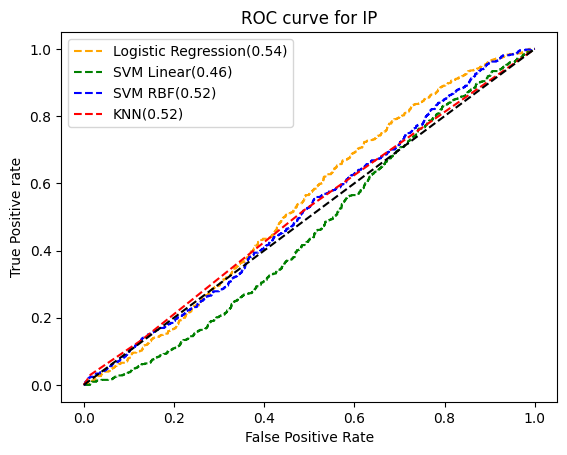

In [70]:
X_druggable = []
X_non_druggable = []

for prot, info in protein_properties.items():
    if prot in druggable_prots:
        X_druggable.append(info['Isoelectric Point'])
    else:
        X_non_druggable.append(info['Isoelectric Point'])

plot_roc_curves(X_druggable, X_non_druggable, feature="IP", setting=1)

##### Instability Index

X_train shape:  (16341, 1)
y_train shape:  (16341,)
X_test shape:  (4086, 1)
y_test shape:  (4086,)
Logistic Regression AUC:  0.6705857112207682
SVM Linear AUC:  0.6705862409645575
SVM RBF AUC:  0.5396775449553823
KNN AUC:  0.5451667501013135


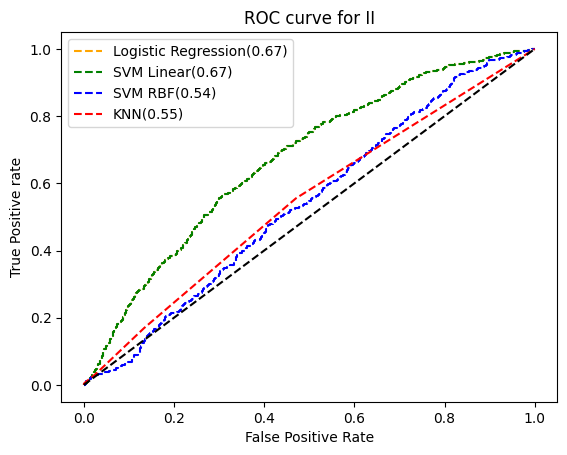

In [71]:
X_druggable = []
X_non_druggable = []

for prot, info in protein_properties.items():
    if prot in druggable_prots:
        X_druggable.append(info['Instability Index'])
    else:
        X_non_druggable.append(info['Instability Index'])

plot_roc_curves(X_druggable, X_non_druggable, feature="II", setting=1)

##### Aromaticity

X_train shape:  (16341, 1)
y_train shape:  (16341,)
X_test shape:  (4086, 1)
y_test shape:  (4086,)
Logistic Regression AUC:  0.6190336943537258
SVM Linear AUC:  0.3809665705181689
SVM RBF AUC:  0.43079533083824006
KNN AUC:  0.5946800479947874


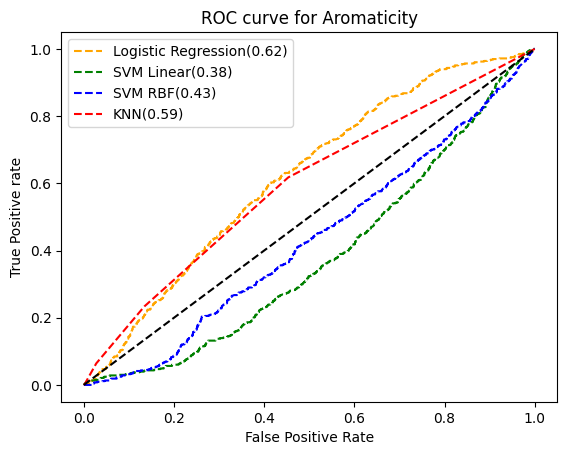

In [72]:
X_druggable = []
X_non_druggable = []

for prot, info in protein_properties.items():
    if prot in druggable_prots:
        X_druggable.append(info['Aromaticity'])
    else:
        X_non_druggable.append(info['Aromaticity'])

plot_roc_curves(X_druggable, X_non_druggable, feature="Aromaticity", setting=1)

##### Seq Length and Mol Weight

X_train shape:  (16341, 2)
y_train shape:  (16341,)
X_test shape:  (4086, 2)
y_test shape:  (4086,)
Logistic Regression AUC:  0.5443027379807757
SVM Linear AUC:  0.459636966581113
SVM RBF AUC:  0.5730588201016579
KNN AUC:  0.5398942101652535


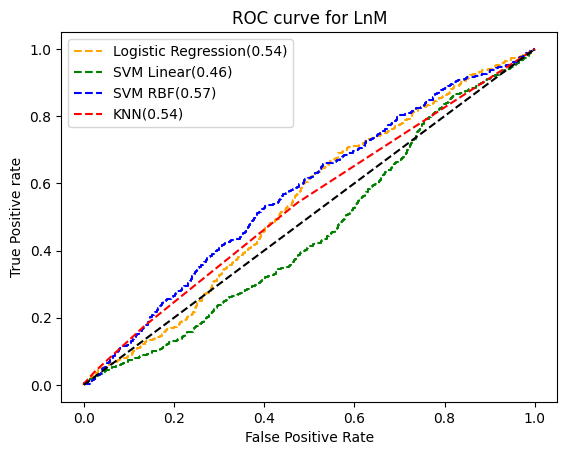

In [73]:
X_druggable = []
X_non_druggable = []

for prot, info in protein_properties.items():
    if prot in druggable_prots:
        X_druggable.append([info['Sequence Length'], info['Molecular Weight']])
    else:
        X_non_druggable.append([info['Sequence Length'], info['Molecular Weight']])

plot_roc_curves(X_druggable, X_non_druggable, feature="LnM", setting=1)

##### Amino Acid Percentage

X_train shape:  (16341, 20)
y_train shape:  (16341,)
X_test shape:  (4086, 20)
y_test shape:  (4086,)
Logistic Regression AUC:  0.7144516754471699
SVM Linear AUC:  0.4517384866809168
SVM RBF AUC:  0.7126478978442077
KNN AUC:  0.7125395652392721


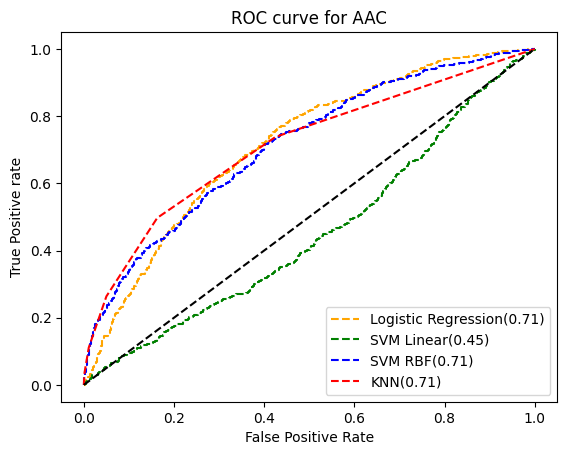

In [76]:
X_druggable = []
X_non_druggable = []

for prot, info in protein_properties.items():
    if prot in druggable_prots:
        X_druggable.append(list(info['Amino Acid Percent'].values()))
    else:
        X_non_druggable.append(list(info['Amino Acid Percent'].values()))

plot_roc_curves(X_druggable, X_non_druggable, feature="AAC", setting=1)

##### All properties

X_train shape:  (16341, 28)
y_train shape:  (16341,)
X_test shape:  (4086, 28)
y_test shape:  (4086,)
Logistic Regression AUC:  0.7179686444651044
SVM Linear AUC:  0.5320455261812624
SVM RBF AUC:  0.7337115703989764
KNN AUC:  0.7468780874130228


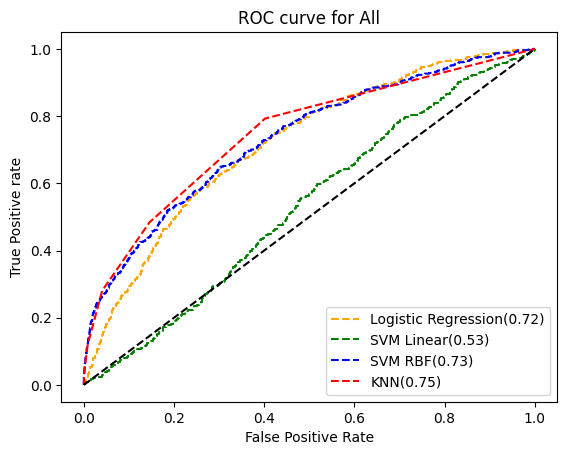

In [5]:
# Here we will investigate all properties at once
# Molar Extinction Coefficient, GRAVY, Isoelectric Point, Instability Index, Aromaticity, Sequence Length, Molecular Weight, Amino Acid Composition
X_druggable = []
X_non_druggable = []

for prot, info in protein_properties.items():   
    if prot in druggable_prots:
        X_druggable.append([info['Molar Extinction Coefficient'][0], info["Molar Extinction Coefficient"][1], info['GRAVY'], info['Isoelectric Point'], info['Instability Index'], info['Aromaticity'], info['Sequence Length'], info['Molecular Weight']] + list(info['Amino Acid Percent'].values()))
    else:
        X_non_druggable.append([info['Molar Extinction Coefficient'][0], info["Molar Extinction Coefficient"][1], info['GRAVY'], info['Isoelectric Point'], info['Instability Index'], info['Aromaticity'], info['Sequence Length'], info['Molecular Weight']] + list(info['Amino Acid Percent'].values()))

plot_roc_curves(X_druggable, X_non_druggable, feature="All", setting=1)